In [1]:
from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsClassifier

In [14]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import sklearn
import sys
from graphviz import Source
from sklearn import tree
from sklearn.tree import export_graphviz
import pydotplus
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, plot_confusion_matrix
# from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
# from sklearn import decomposition, datasets
from sklearn import tree
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
# from sklearn.model_selection import ParameterGrid
# from sklearn.metrics import mean_squared_error

# Python ≥3.5 is required
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
assert sklearn.__version__ >= "0.20"

# To plot pretty figures
%matplotlib inline
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
plt.style.use('fivethirtyeight')

# to make this notebook's output stable across runs
np.random.seed(42)

IMAGE_PATH = os.path.join('./images')


def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGE_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)


# Loading the data

In [3]:
DATA_PATH = '../MLP2/input/'

# loading the audio file data
audio_df = pd.read_csv(DATA_PATH+'audio_data.csv') # we probably wont use this until we know how to neural network
audio_means_df = pd.read_csv(
    DATA_PATH + 'audio_means.csv')

# loading the .csv file data
song_dropped_df = pd.read_csv(
    DATA_PATH + 'dropped.csv')
song_filled_df = pd.read_csv(
    DATA_PATH + 'mean_filled.csv')

In [4]:
song_dropped_df = song_dropped_df.drop(columns=['artist_name','track_name','instance_id'])
song_filled_df = song_filled_df.drop(columns=['artist_name','track_name'])

In [5]:
keys = dict()
i = 0
for key in sorted(song_filled_df['key'].unique()):
    keys[key] = i
    i+=1

modes = dict({song_filled_df['mode'].unique()[0]:0, song_filled_df['mode'].unique()[1]:1})

In [6]:
song_dropped_df['key'] = song_dropped_df['key'].apply(lambda x: keys[x])
song_dropped_df['mode'] = song_dropped_df['mode'].apply(lambda x: modes[x])

song_filled_df['key'] = song_filled_df['key'].apply(lambda x: keys[x])
song_filled_df['mode'] = song_filled_df['mode'].apply(lambda x: modes[x])

In [7]:
audio_genres = audio_df['genre'].unique()
dropped_genres = song_dropped_df['music_genre'].unique()
filled_genres = song_filled_df['music_genre'].unique()

audio_features = audio_means_df.columns.drop('genre')
dropped_features = song_dropped_df.columns.drop('music_genre')
filled_features = song_filled_df.columns.drop('music_genre')

# Modeling

## Splitting the data

Separating data from labels

In [8]:
# audio data with means
X_audio = audio_means_df.loc[:, audio_means_df.columns != 'genre']
y_audio = audio_means_df['genre']

# song data with dropped null values
X_dropped = song_dropped_df.loc[:, song_dropped_df.columns != 'music_genre']
y_dropped = song_dropped_df['music_genre']

# song data with mean filled null values
X_filled = song_filled_df.loc[:, song_filled_df.columns != 'music_genre']
y_filled = song_filled_df['music_genre']

In [9]:
print(len(X_audio))
print(len(X_dropped))
print(len(X_filled))

1000
40560
50000


creating the splits

In [10]:
# audio data with means
X_audio_train, X_audio_test, y_audio_train, y_audio_test = train_test_split(
    X_audio, y_audio, test_size=0.20)

X_dropped_train, X_dropped_test, y_dropped_train, y_dropped_test = train_test_split(
    X_dropped, y_dropped, test_size=0.30)

X_filled_train, X_filled_test, y_filled_train, y_filled_test = train_test_split(
    X_filled, y_filled, test_size=0.30)


## Training

In [12]:
# def test_splits(pipe, params, X, y, df, model, test_size=[.15,0.2, 0.25, 0.3]):
#     for size in test_size:
#         X_train, X_test, y_train, y_test = train_test_split(X_audio, y_audio, test_size=size)

def run_GSCV(pipe, params, X, y, label):
    clf_GSCV = GridSearchCV(pipe, params)
    clf_GSCV.fit(X, y)
    df = pd.DataFrame(clf_GSCV.cv_results_)
    df['label'] = label
    return df

### Decision Tree

In [15]:
sc = StandardScaler()
dtreeClf = tree.DecisionTreeClassifier()

pipe = Pipeline(steps=[('sc', sc),
                       ('dtreeClf', dtreeClf)])

n_components = list(range(1, X_audio.shape[1] + 1, 1))

criterion = ['gini', 'entropy']
max_depth = [4, 6, 8, 10]

parameters = dict(
                  dtreeClf__criterion=criterion,
                  dtreeClf__max_depth=max_depth)
                  
tree_results_df = pd.DataFrame()
tree_results_df = tree_results_df.append(
    run_GSCV(pipe, parameters, X_audio, y_audio, 'Audio')).append(
    run_GSCV(pipe, parameters, X_dropped, y_dropped, 'Dropped')).append(
    run_GSCV(pipe, parameters, X_filled, y_filled, 'Filled'))

In [16]:
best_audio_tree = tree_results_df[(tree_results_df.rank_test_score == 1) &
                (tree_results_df.label == 'Audio')]

best_dropped_tree = tree_results_df[(tree_results_df.rank_test_score == 1) &
                                  (tree_results_df.label == 'Dropped')]

best_filled_tree = tree_results_df[(tree_results_df.rank_test_score == 1) &
                                    (tree_results_df.label == 'Filled')]

In [17]:

clf_audio = DecisionTreeClassifier(
    criterion=best_audio_tree['param_dtreeClf__criterion'].values[0],
    max_depth=best_audio_tree['param_dtreeClf__max_depth'].values[0]).fit(X_audio_train, y_audio_train)

clf_dropped = DecisionTreeClassifier(
    criterion=best_dropped_tree['param_dtreeClf__criterion'].values[0],
    max_depth=best_dropped_tree['param_dtreeClf__max_depth'].values[0]).fit(X_dropped_train, y_dropped_train)

clf_filled = DecisionTreeClassifier(
    criterion=best_filled_tree['param_dtreeClf__criterion'].values[0],
    max_depth=best_filled_tree['param_dtreeClf__max_depth'].values[0]).fit(X_filled_train, y_filled_train)

y_pred_audio = clf_audio.predict(X_audio_test)
y_pred_dropped = clf_dropped.predict(X_dropped_test)
y_pred_filled = clf_filled.predict(X_filled_test)

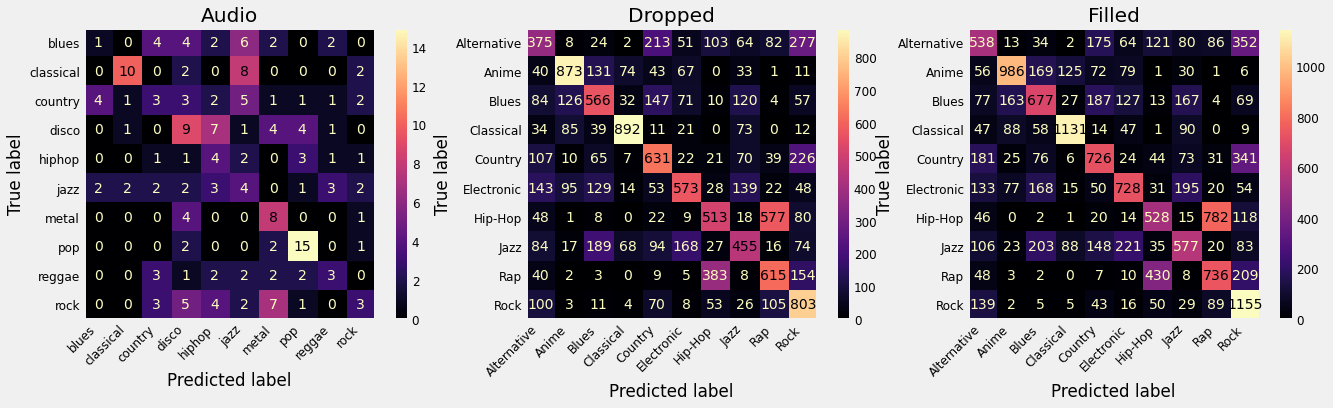

In [18]:
fig, axs = plt.subplots(1,3, figsize = (20,5))

plot_confusion_matrix(clf_audio, X_audio_test, y_audio_test, ax=axs[0], cmap = 'magma')
plot_confusion_matrix(clf_dropped, X_dropped_test,
                      y_dropped_test, ax=axs[1], cmap='magma')
plot_confusion_matrix(clf_filled, X_filled_test,
                      y_filled_test, ax=axs[2], cmap='magma')

axs[0].set(title='Audio')
axs[1].set(title='Dropped')
axs[2].set(title='Filled')

for i in range(3):
    axs[i].set_xticklabels(
        axs[i].get_xticklabels(),
        rotation=45,
        horizontalalignment='right'
    )
    axs[i].grid(False)

plt.show()

In [19]:
result_metrics_audio = classification_report(y_audio_test, y_pred_audio)
result_metrics_dropped = classification_report(y_dropped_test, y_pred_dropped)
result_metrics_filled = classification_report(y_filled_test, y_pred_filled)

print('\n\nAudio\n', result_metrics_audio)
print('\n\nDropped\n', result_metrics_dropped)
print('\n\nFilled\n',result_metrics_filled)



Audio
               precision    recall  f1-score   support

       blues       0.14      0.05      0.07        21
   classical       0.71      0.45      0.56        22
     country       0.19      0.13      0.15        23
       disco       0.27      0.33      0.30        27
      hiphop       0.17      0.31      0.22        13
        jazz       0.13      0.19      0.16        21
       metal       0.31      0.62      0.41        13
         pop       0.56      0.75      0.64        20
      reggae       0.27      0.20      0.23        15
        rock       0.25      0.12      0.16        25

    accuracy                           0.30       200
   macro avg       0.30      0.31      0.29       200
weighted avg       0.30      0.30      0.29       200



Dropped
               precision    recall  f1-score   support

 Alternative       0.36      0.31      0.33      1199
       Anime       0.72      0.69      0.70      1273
       Blues       0.49      0.47      0.48      1217
   C

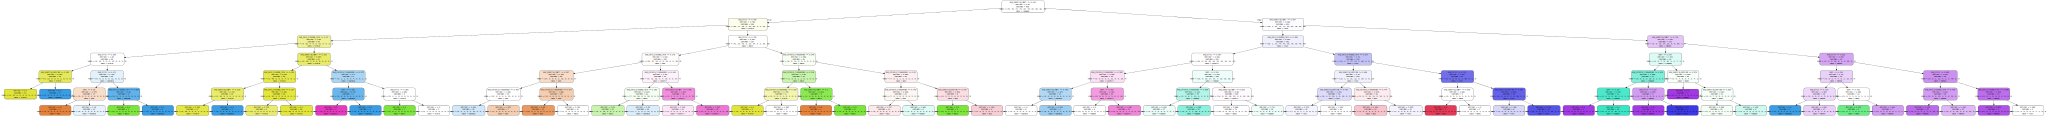

In [20]:
dot_data = export_graphviz(
    clf_audio,
    rounded=True,
    filled=True,
    feature_names=audio_features,
    class_names=audio_genres
)

out_file = os.path.join(IMAGE_PATH, "audio_tree.pdf")

pydot_graph = pydotplus.graph_from_dot_data(dot_data)
pydot_graph.set_size('"65,50!"')
pydot_graph.write_pdf(out_file)
Source(pydot_graph.to_string())


In [21]:
dot_data = export_graphviz(
    clf_dropped,
    rounded=True,
    filled=True,
    feature_names=dropped_features,
    class_names=dropped_features
)

out_file = os.path.join(IMAGE_PATH, "dropped_tree.pdf")

pydot_graph = pydotplus.graph_from_dot_data(dot_data)
pydot_graph.set_size('"100,100!"')
pydot_graph.write_pdf(out_file)
Source(pydot_graph.to_string())


In [22]:
dot_data = export_graphviz(
    clf_filled,
    rounded=True,
    filled=True,
    feature_names=filled_features,
    class_names=filled_features
)
out_file = os.path.join(IMAGE_PATH, "filled_tree.pdf")

pydot_graph = pydotplus.graph_from_dot_data(dot_data)
pydot_graph.set_size('"100,100!"')
pydot_graph.write_pdf(out_file)
Source(pydot_graph.to_string())

### kNN Classifier

c:\Users\alexs\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
c:\Users\alexs\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
c:\Users\alexs\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confus

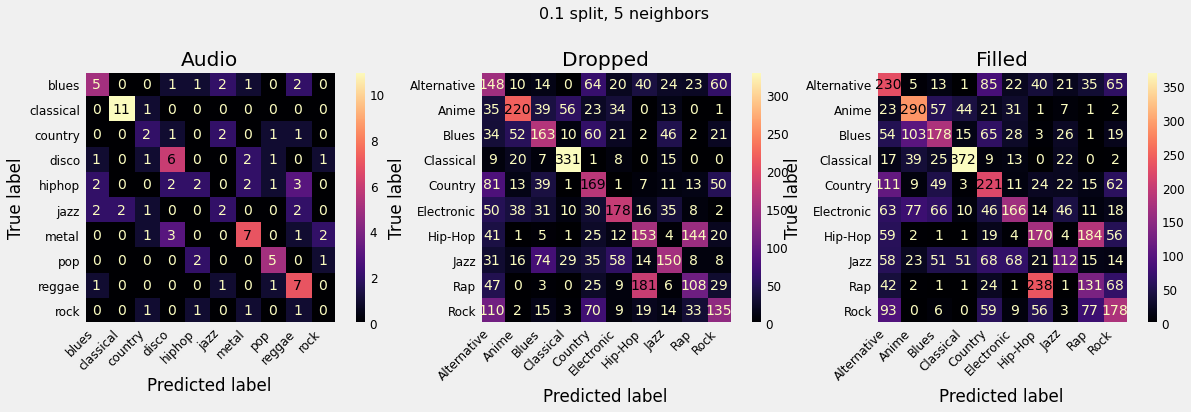



0.1 Split, 5 Neighbors:



Audio
               precision    recall  f1-score   support

       blues       0.45      0.42      0.43        12
   classical       0.85      0.92      0.88        12
     country       0.29      0.29      0.29         7
       disco       0.46      0.50      0.48        12
      hiphop       0.33      0.17      0.22        12
        jazz       0.29      0.22      0.25         9
       metal       0.54      0.50      0.52        14
         pop       0.56      0.62      0.59         8
      reggae       0.41      0.70      0.52        10
        rock       0.00      0.00      0.00         4

    accuracy                           0.47       100
   macro avg       0.42      0.43      0.42       100
weighted avg       0.46      0.47      0.46       100



Dropped
               precision    recall  f1-score   support

 Alternative       0.25      0.37      0.30       403
       Anime       0.59      0.52      0.55       421
       Blues       0.42      0.

c:\Users\alexs\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
c:\Users\alexs\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
c:\Users\alexs\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confus

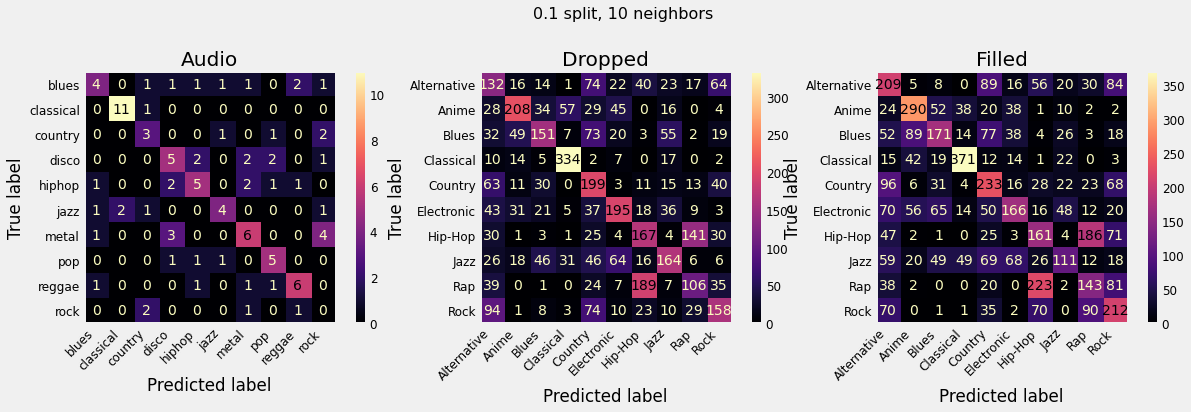



0.1 Split, 10 Neighbors:



Audio
               precision    recall  f1-score   support

       blues       0.50      0.33      0.40        12
   classical       0.85      0.92      0.88        12
     country       0.38      0.43      0.40         7
       disco       0.42      0.42      0.42        12
      hiphop       0.50      0.42      0.45        12
        jazz       0.57      0.44      0.50         9
       metal       0.46      0.43      0.44        14
         pop       0.50      0.62      0.56         8
      reggae       0.60      0.60      0.60        10
        rock       0.00      0.00      0.00         4

    accuracy                           0.49       100
   macro avg       0.48      0.46      0.47       100
weighted avg       0.51      0.49      0.50       100



Dropped
               precision    recall  f1-score   support

 Alternative       0.27      0.33      0.29       403
       Anime       0.60      0.49      0.54       421
       Blues       0.48      0

c:\Users\alexs\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
c:\Users\alexs\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
c:\Users\alexs\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confus

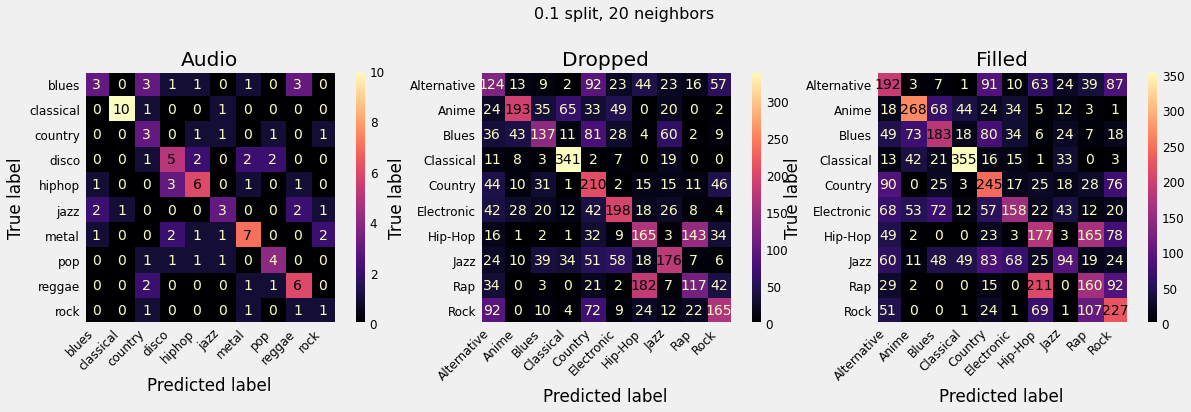



0.1 Split, 20 Neighbors:



Audio
               precision    recall  f1-score   support

       blues       0.43      0.25      0.32        12
   classical       0.91      0.83      0.87        12
     country       0.25      0.43      0.32         7
       disco       0.42      0.42      0.42        12
      hiphop       0.50      0.50      0.50        12
        jazz       0.43      0.33      0.38         9
       metal       0.54      0.50      0.52        14
         pop       0.50      0.50      0.50         8
      reggae       0.46      0.60      0.52        10
        rock       0.20      0.25      0.22         4

    accuracy                           0.48       100
   macro avg       0.46      0.46      0.46       100
weighted avg       0.50      0.48      0.48       100



Dropped
               precision    recall  f1-score   support

 Alternative       0.28      0.31      0.29       403
       Anime       0.63      0.46      0.53       421
       Blues       0.47      0

c:\Users\alexs\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
c:\Users\alexs\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
c:\Users\alexs\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confus

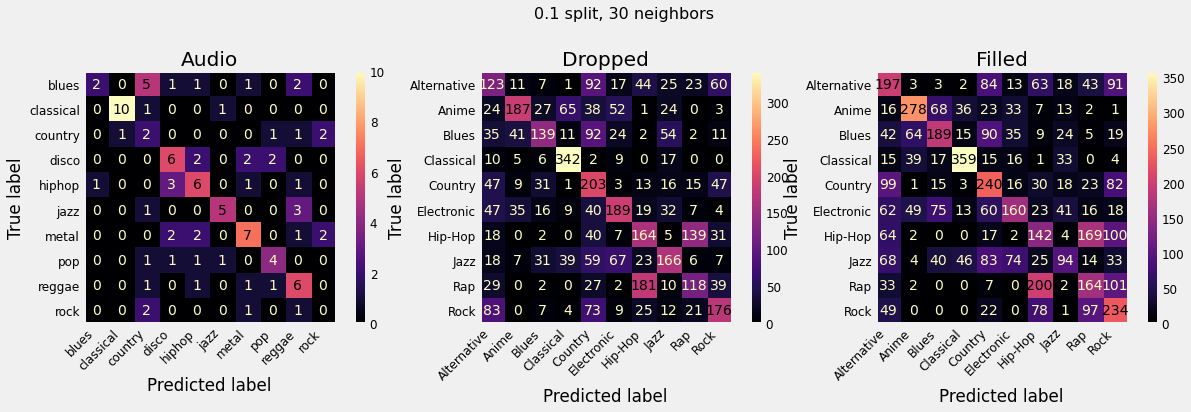



0.1 Split, 30 Neighbors:



Audio
               precision    recall  f1-score   support

       blues       0.67      0.17      0.27        12
   classical       0.91      0.83      0.87        12
     country       0.15      0.29      0.20         7
       disco       0.46      0.50      0.48        12
      hiphop       0.46      0.50      0.48        12
        jazz       0.71      0.56      0.63         9
       metal       0.54      0.50      0.52        14
         pop       0.50      0.50      0.50         8
      reggae       0.40      0.60      0.48        10
        rock       0.00      0.00      0.00         4

    accuracy                           0.48       100
   macro avg       0.48      0.44      0.44       100
weighted avg       0.53      0.48      0.48       100



Dropped
               precision    recall  f1-score   support

 Alternative       0.28      0.31      0.29       403
       Anime       0.63      0.44      0.52       421
       Blues       0.52      0

c:\Users\alexs\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
c:\Users\alexs\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
c:\Users\alexs\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confus

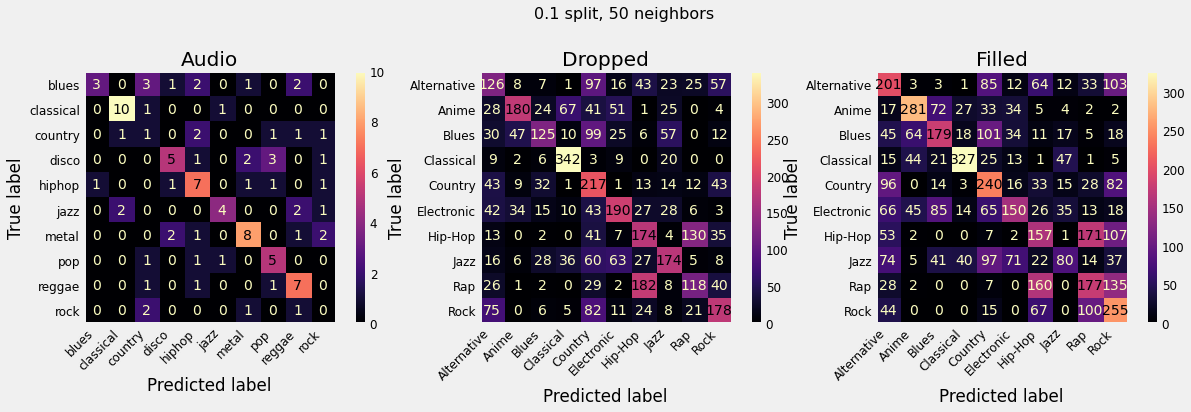



0.1 Split, 50 Neighbors:



Audio
               precision    recall  f1-score   support

       blues       0.75      0.25      0.38        12
   classical       0.77      0.83      0.80        12
     country       0.11      0.14      0.12         7
       disco       0.56      0.42      0.48        12
      hiphop       0.47      0.58      0.52        12
        jazz       0.67      0.44      0.53         9
       metal       0.62      0.57      0.59        14
         pop       0.45      0.62      0.53         8
      reggae       0.50      0.70      0.58        10
        rock       0.00      0.00      0.00         4

    accuracy                           0.50       100
   macro avg       0.49      0.46      0.45       100
weighted avg       0.55      0.50      0.50       100



Dropped
               precision    recall  f1-score   support

 Alternative       0.31      0.31      0.31       403
       Anime       0.63      0.43      0.51       421
       Blues       0.51      0

c:\Users\alexs\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
c:\Users\alexs\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
c:\Users\alexs\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confus

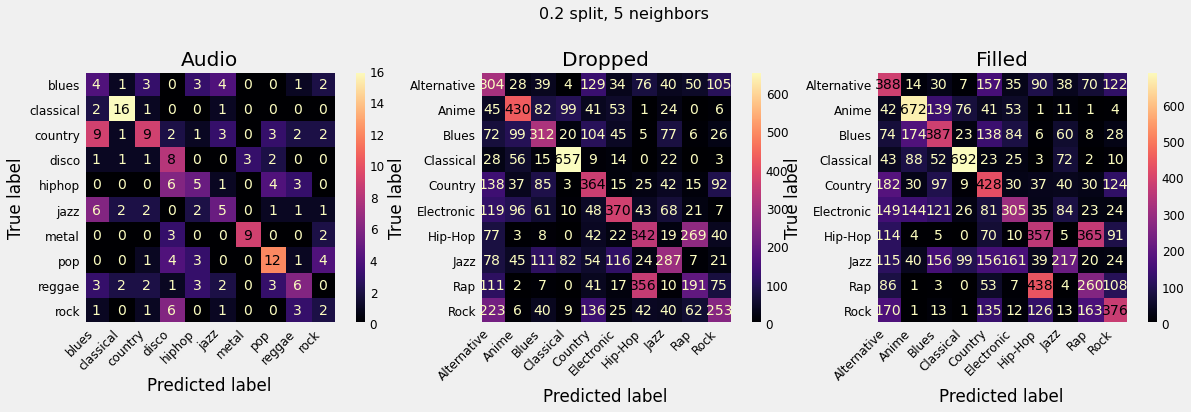



0.2 Split, 5 Neighbors:



Audio
               precision    recall  f1-score   support

       blues       0.15      0.22      0.18        18
   classical       0.70      0.80      0.74        20
     country       0.45      0.28      0.35        32
       disco       0.27      0.50      0.35        16
      hiphop       0.29      0.26      0.28        19
        jazz       0.29      0.25      0.27        20
       metal       0.75      0.64      0.69        14
         pop       0.48      0.48      0.48        25
      reggae       0.35      0.27      0.31        22
        rock       0.15      0.14      0.15        14

    accuracy                           0.38       200
   macro avg       0.39      0.39      0.38       200
weighted avg       0.40      0.38      0.38       200



Dropped
               precision    recall  f1-score   support

 Alternative       0.25      0.38      0.30       809
       Anime       0.54      0.55      0.54       781
       Blues       0.41      0.

c:\Users\alexs\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
c:\Users\alexs\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
c:\Users\alexs\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confus

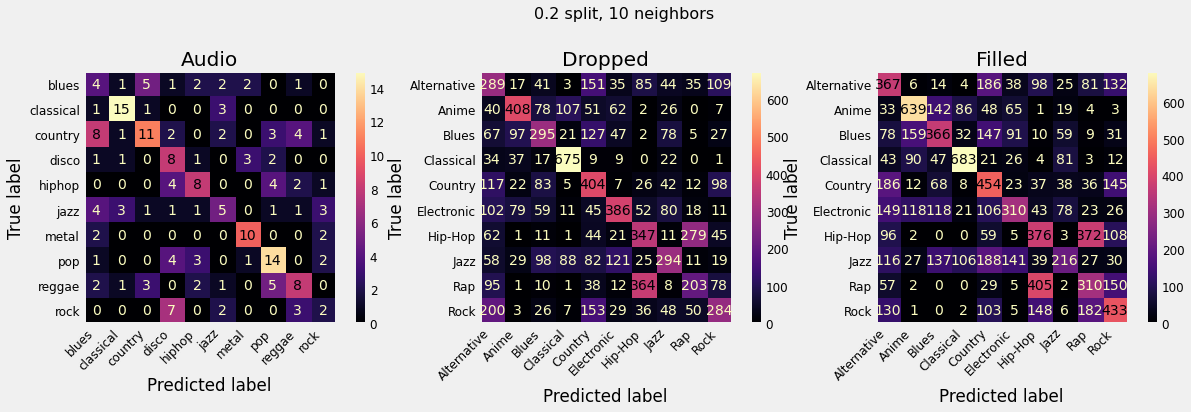



0.2 Split, 10 Neighbors:



Audio
               precision    recall  f1-score   support

       blues       0.17      0.22      0.20        18
   classical       0.68      0.75      0.71        20
     country       0.52      0.34      0.42        32
       disco       0.30      0.50      0.37        16
      hiphop       0.47      0.42      0.44        19
        jazz       0.33      0.25      0.29        20
       metal       0.62      0.71      0.67        14
         pop       0.48      0.56      0.52        25
      reggae       0.42      0.36      0.39        22
        rock       0.18      0.14      0.16        14

    accuracy                           0.42       200
   macro avg       0.42      0.43      0.42       200
weighted avg       0.43      0.42      0.42       200



Dropped
               precision    recall  f1-score   support

 Alternative       0.27      0.36      0.31       809
       Anime       0.59      0.52      0.55       781
       Blues       0.41      0

c:\Users\alexs\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
c:\Users\alexs\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
c:\Users\alexs\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confus

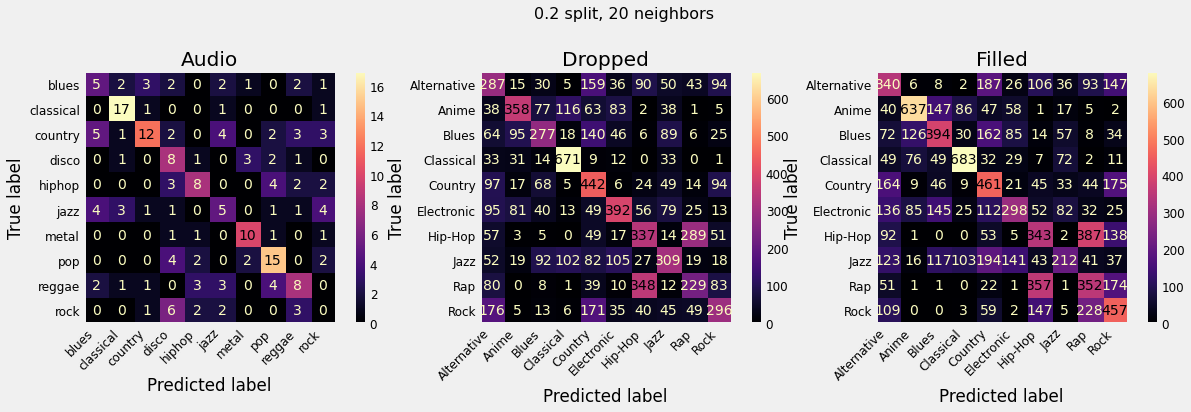



0.2 Split, 20 Neighbors:



Audio
               precision    recall  f1-score   support

       blues       0.31      0.28      0.29        18
   classical       0.68      0.85      0.76        20
     country       0.63      0.38      0.47        32
       disco       0.30      0.50      0.37        16
      hiphop       0.47      0.42      0.44        19
        jazz       0.29      0.25      0.27        20
       metal       0.62      0.71      0.67        14
         pop       0.52      0.60      0.56        25
      reggae       0.40      0.36      0.38        22
        rock       0.00      0.00      0.00        14

    accuracy                           0.44       200
   macro avg       0.42      0.44      0.42       200
weighted avg       0.45      0.44      0.43       200



Dropped
               precision    recall  f1-score   support

 Alternative       0.29      0.35      0.32       809
       Anime       0.57      0.46      0.51       781
       Blues       0.44      0

c:\Users\alexs\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
c:\Users\alexs\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
c:\Users\alexs\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confus

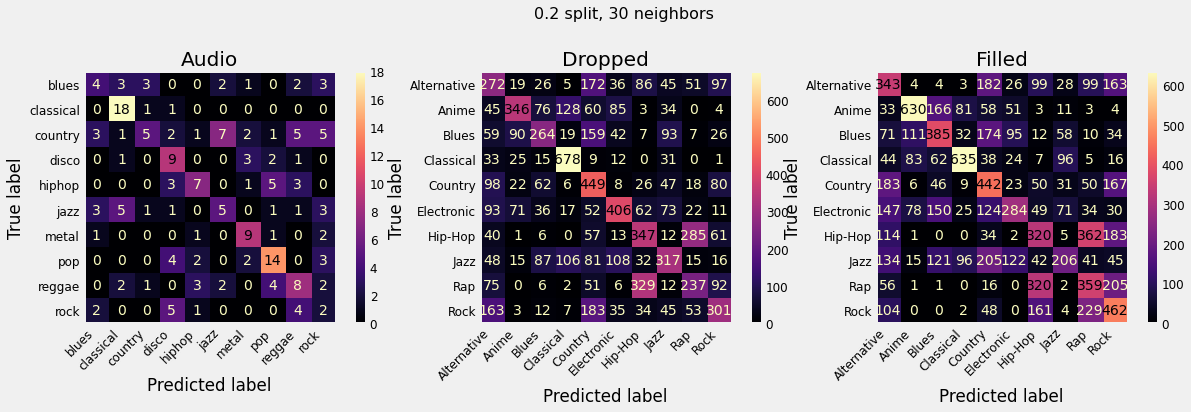



0.2 Split, 30 Neighbors:



Audio
               precision    recall  f1-score   support

       blues       0.31      0.22      0.26        18
   classical       0.60      0.90      0.72        20
     country       0.45      0.16      0.23        32
       disco       0.36      0.56      0.44        16
      hiphop       0.47      0.37      0.41        19
        jazz       0.31      0.25      0.28        20
       metal       0.50      0.64      0.56        14
         pop       0.50      0.56      0.53        25
      reggae       0.33      0.36      0.35        22
        rock       0.10      0.14      0.12        14

    accuracy                           0.41       200
   macro avg       0.39      0.42      0.39       200
weighted avg       0.41      0.41      0.39       200



Dropped
               precision    recall  f1-score   support

 Alternative       0.29      0.34      0.31       809
       Anime       0.58      0.44      0.50       781
       Blues       0.45      0

c:\Users\alexs\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
c:\Users\alexs\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
c:\Users\alexs\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confus

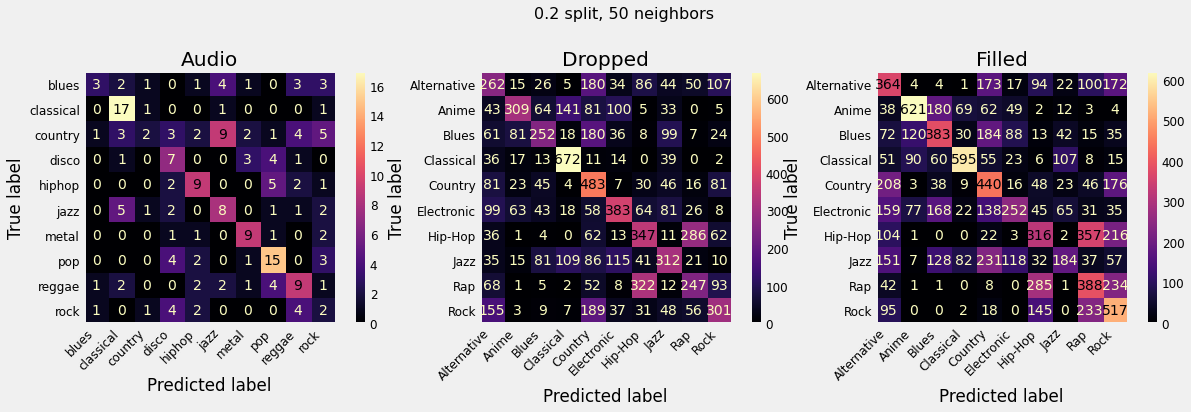



0.2 Split, 50 Neighbors:



Audio
               precision    recall  f1-score   support

       blues       0.50      0.17      0.25        18
   classical       0.57      0.85      0.68        20
     country       0.33      0.06      0.11        32
       disco       0.30      0.44      0.36        16
      hiphop       0.47      0.47      0.47        19
        jazz       0.33      0.40      0.36        20
       metal       0.53      0.64      0.58        14
         pop       0.48      0.60      0.54        25
      reggae       0.38      0.41      0.39        22
        rock       0.10      0.14      0.12        14

    accuracy                           0.41       200
   macro avg       0.40      0.42      0.39       200
weighted avg       0.40      0.41      0.38       200



Dropped
               precision    recall  f1-score   support

 Alternative       0.30      0.32      0.31       809
       Anime       0.59      0.40      0.47       781
       Blues       0.46      0

c:\Users\alexs\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
c:\Users\alexs\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
c:\Users\alexs\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confus

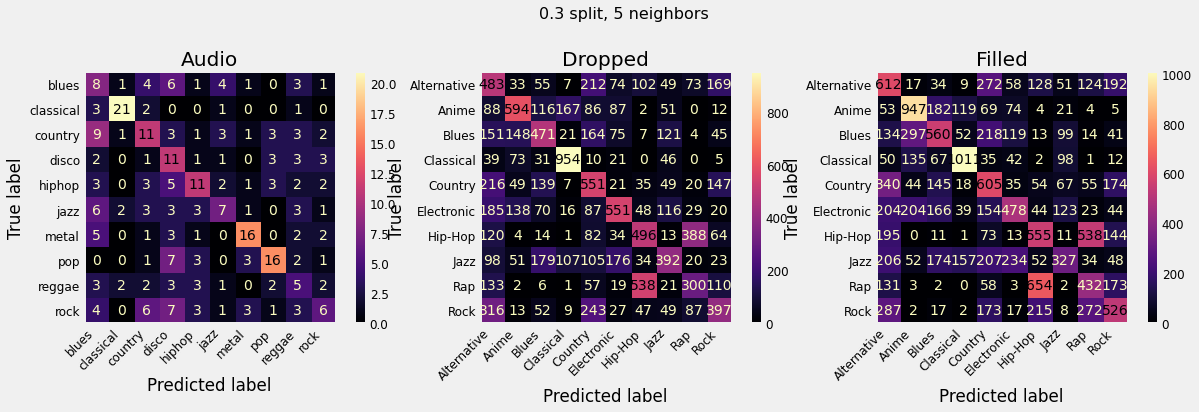



0.3 Split, 5 Neighbors:



Audio
               precision    recall  f1-score   support

       blues       0.19      0.28      0.22        29
   classical       0.78      0.75      0.76        28
     country       0.32      0.30      0.31        37
       disco       0.23      0.44      0.30        25
      hiphop       0.41      0.34      0.37        32
        jazz       0.35      0.24      0.29        29
       metal       0.62      0.53      0.57        30
         pop       0.57      0.48      0.52        33
      reggae       0.19      0.22      0.20        23
        rock       0.30      0.18      0.22        34

    accuracy                           0.37       300
   macro avg       0.39      0.38      0.38       300
weighted avg       0.40      0.37      0.38       300



Dropped
               precision    recall  f1-score   support

 Alternative       0.26      0.38      0.31      1257
       Anime       0.54      0.49      0.51      1203
       Blues       0.42      0.

c:\Users\alexs\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
c:\Users\alexs\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
c:\Users\alexs\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confus

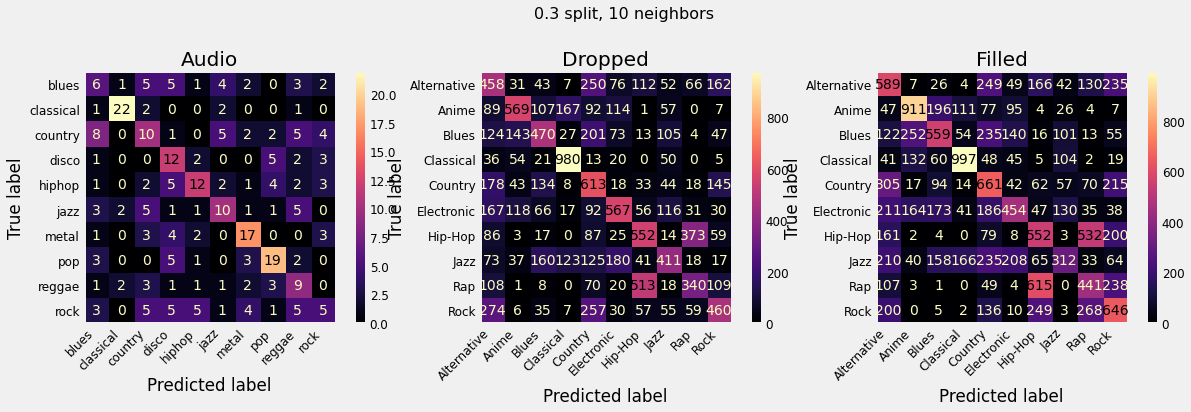



0.3 Split, 10 Neighbors:



Audio
               precision    recall  f1-score   support

       blues       0.21      0.21      0.21        29
   classical       0.81      0.79      0.80        28
     country       0.29      0.27      0.28        37
       disco       0.31      0.48      0.38        25
      hiphop       0.48      0.38      0.42        32
        jazz       0.40      0.34      0.37        29
       metal       0.53      0.57      0.55        30
         pop       0.54      0.58      0.56        33
      reggae       0.26      0.39      0.32        23
        rock       0.25      0.15      0.19        34

    accuracy                           0.41       300
   macro avg       0.41      0.41      0.41       300
weighted avg       0.41      0.41      0.40       300



Dropped
               precision    recall  f1-score   support

 Alternative       0.29      0.36      0.32      1257
       Anime       0.57      0.47      0.52      1203
       Blues       0.44      0

c:\Users\alexs\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
c:\Users\alexs\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
c:\Users\alexs\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confus

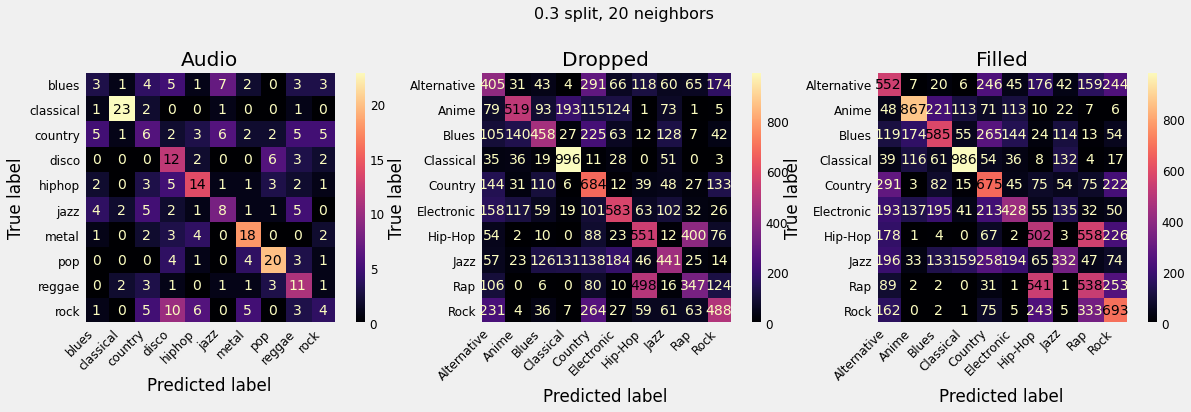



0.3 Split, 20 Neighbors:



Audio
               precision    recall  f1-score   support

       blues       0.18      0.10      0.13        29
   classical       0.79      0.82      0.81        28
     country       0.20      0.16      0.18        37
       disco       0.27      0.48      0.35        25
      hiphop       0.44      0.44      0.44        32
        jazz       0.33      0.28      0.30        29
       metal       0.53      0.60      0.56        30
         pop       0.57      0.61      0.59        33
      reggae       0.31      0.48      0.37        23
        rock       0.21      0.12      0.15        34

    accuracy                           0.40       300
   macro avg       0.38      0.41      0.39       300
weighted avg       0.38      0.40      0.38       300



Dropped
               precision    recall  f1-score   support

 Alternative       0.29      0.32      0.31      1257
       Anime       0.57      0.43      0.49      1203
       Blues       0.48      0

c:\Users\alexs\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
c:\Users\alexs\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
c:\Users\alexs\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confus

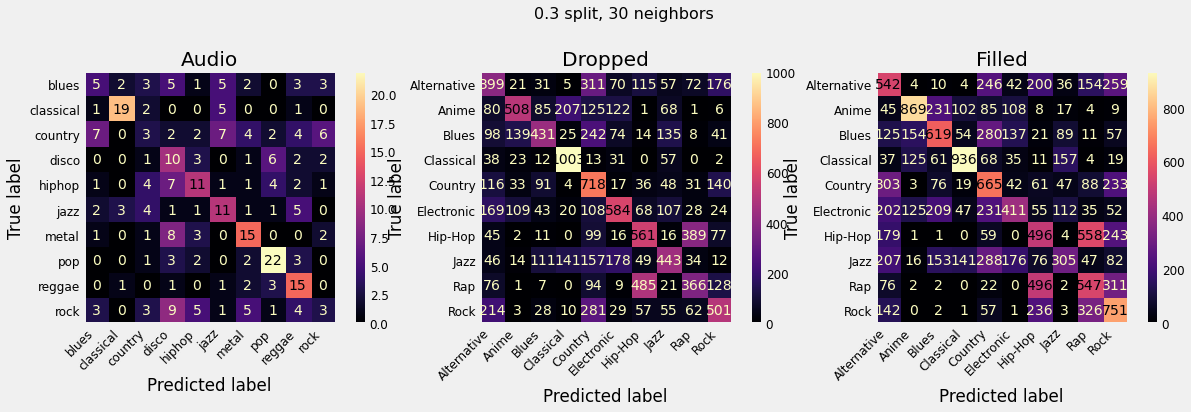



0.3 Split, 30 Neighbors:



Audio
               precision    recall  f1-score   support

       blues       0.25      0.17      0.20        29
   classical       0.76      0.68      0.72        28
     country       0.14      0.08      0.10        37
       disco       0.22      0.40      0.28        25
      hiphop       0.39      0.34      0.37        32
        jazz       0.35      0.38      0.37        29
       metal       0.45      0.50      0.48        30
         pop       0.56      0.67      0.61        33
      reggae       0.38      0.65      0.48        23
        rock       0.18      0.09      0.12        34

    accuracy                           0.38       300
   macro avg       0.37      0.40      0.37       300
weighted avg       0.36      0.38      0.36       300



Dropped
               precision    recall  f1-score   support

 Alternative       0.31      0.32      0.31      1257
       Anime       0.60      0.42      0.49      1203
       Blues       0.51      0

c:\Users\alexs\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
c:\Users\alexs\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
c:\Users\alexs\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confus

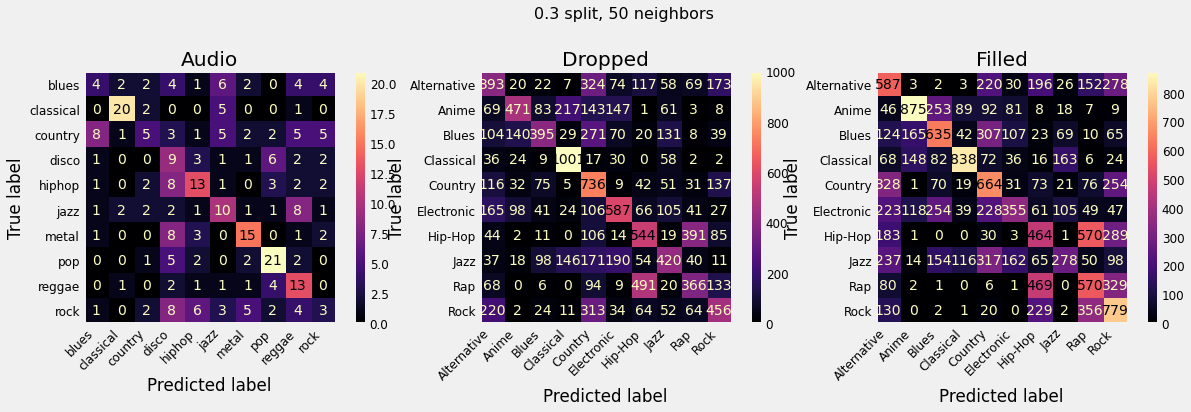



0.3 Split, 50 Neighbors:



Audio
               precision    recall  f1-score   support

       blues       0.24      0.14      0.17        29
   classical       0.77      0.71      0.74        28
     country       0.31      0.14      0.19        37
       disco       0.18      0.36      0.24        25
      hiphop       0.42      0.41      0.41        32
        jazz       0.31      0.34      0.33        29
       metal       0.52      0.50      0.51        30
         pop       0.54      0.64      0.58        33
      reggae       0.31      0.57      0.40        23
        rock       0.16      0.09      0.11        34

    accuracy                           0.38       300
   macro avg       0.38      0.39      0.37       300
weighted avg       0.38      0.38      0.36       300



Dropped
               precision    recall  f1-score   support

 Alternative       0.31      0.31      0.31      1257
       Anime       0.58      0.39      0.47      1203
       Blues       0.52      0

In [44]:
splits = [.10, .20, .30]
neighbor_counts = [5, 10, 20, 30, 50]

for split in splits:
    X_audio_train, X_audio_test, y_audio_train, y_audio_test = train_test_split(
        X_audio, y_audio, test_size=split)

    X_dropped_train, X_dropped_test, y_dropped_train, y_dropped_test = train_test_split(
        X_dropped, y_dropped, test_size=split)

    X_filled_train, X_filled_test, y_filled_train, y_filled_test = train_test_split(
        X_filled, y_filled, test_size=split)
    for count in neighbor_counts:
        knn_audio = KNeighborsClassifier(n_neighbors=count).fit(X_audio_train, y_audio_train)
        knn_dropped = KNeighborsClassifier(n_neighbors=count).fit(X_dropped_train, y_dropped_train)
        knn_filled = KNeighborsClassifier(n_neighbors=count).fit(X_filled_train, y_filled_train)

        y_pred_knn_audio = knn_audio.predict(X_audio_test)
        y_pred_knn_dropped = knn_dropped.predict(X_dropped_test)
        y_pred_knn_filled = knn_filled.predict(X_filled_test)

        fig, axs = plt.subplots(1,3, figsize = (20,5))

        plot_confusion_matrix(knn_audio, X_audio_test, y_audio_test, ax=axs[0], cmap = 'magma')
        plot_confusion_matrix(knn_dropped, X_dropped_test,
                            y_dropped_test, ax=axs[1], cmap='magma')
        plot_confusion_matrix(knn_filled, X_filled_test,
                            y_filled_test, ax=axs[2], cmap='magma')

        axs[0].set(title='Audio')
        axs[1].set(title='Dropped')
        axs[2].set(title='Filled')

        for i in range(3):
            axs[i].set_xticklabels(
                axs[i].get_xticklabels(),
                rotation=45,
                horizontalalignment='right'
            )
            axs[i].grid(False)
        
        fig.suptitle((str(split) + " split, " + str(count) + " neighbors"), fontsize=16)
        plt.subplots_adjust(left=0.1,
                            bottom=0.1,
                            right=0.9,
                            top=0.8,
                            wspace=0.1,
                            hspace=0.4)
        plt.show()
        knn_result_metrics_audio = classification_report(y_audio_test, y_pred_knn_audio)
        knn_result_metrics_dropped = classification_report(y_dropped_test, y_pred_knn_dropped)
        knn_result_metrics_filled = classification_report(y_filled_test, y_pred_knn_filled)

        print('\n\n' + str(split) + ' Split, ' + str(count) + ' Neighbors:\n')
        print('\n\nAudio\n', knn_result_metrics_audio)
        print('\n\nDropped\n', knn_result_metrics_dropped)
        print('\n\nFilled\n', knn_result_metrics_filled)

In [ ]:
# Optimal for audio: 0.1 Split, 20 Neighbors
# 0.1 Split, 10 Neighbors
# 0.1 Split, 20 Neighbors

# X_audio_train, X_audio_test, y_audio_train, y_audio_test = train_test_split(
#         X_audio, y_audio, test_size=split)

# X_dropped_train, X_dropped_test, y_dropped_train, y_dropped_test = train_test_split(
#     X_dropped, y_dropped, test_size=split)

# X_filled_train, X_filled_test, y_filled_train, y_filled_test = train_test_split(
#     X_filled, y_filled, test_size=split)

# knn_audio = KNeighborsClassifier(n_neighbors=count).fit(X_audio_train, y_audio_train)
# knn_dropped = KNeighborsClassifier(n_neighbors=count).fit(X_dropped_train, y_dropped_train)
# knn_filled = KNeighborsClassifier(n_neighbors=count).fit(X_filled_train, y_filled_train)

# y_pred_knn_audio = knn_audio.predict(X_audio_test)
# y_pred_knn_dropped = knn_dropped.predict(X_dropped_test)
# y_pred_knn_filled = knn_filled.predict(X_filled_test)

# fig, axs = plt.subplots(1,3, figsize = (20,5))

# plot_confusion_matrix(knn_audio, X_audio_test, y_audio_test, ax=axs[0], cmap = 'magma')
# plot_confusion_matrix(knn_dropped, X_dropped_test,
#                     y_dropped_test, ax=axs[1], cmap='magma')
# plot_confusion_matrix(knn_filled, X_filled_test,
#                     y_filled_test, ax=axs[2], cmap='magma')

# axs[0].set(title='Audio')
# axs[1].set(title='Dropped')
# axs[2].set(title='Filled')

# for i in range(3):
#     axs[i].set_xticklabels(
#         axs[i].get_xticklabels(),
#         rotation=45,
#         horizontalalignment='right'
#     )
#     axs[i].grid(False)

# fig.suptitle((str(split) + " split, " + str(count) + " neighbors"), fontsize=16)
# plt.subplots_adjust(left=0.1,
#                     bottom=0.1,
#                     right=0.9,
#                     top=0.8,
#                     wspace=0.1,
#                     hspace=0.4)
# plt.show()
# knn_result_metrics_audio = classification_report(y_audio_test, y_pred_knn_audio)
# knn_result_metrics_dropped = classification_report(y_dropped_test, y_pred_knn_dropped)
# knn_result_metrics_filled = classification_report(y_filled_test, y_pred_knn_filled)

# print('\n\n' + str(split) + ' Split, ' + str(count) + ' Neighbors:\n')
# print('\n\nAudio\n', knn_result_metrics_audio)
# print('\n\nDropped\n', knn_result_metrics_dropped)
# print('\n\nFilled\n', knn_result_metrics_filled)

In [ ]:
# Optimal for audio: 0.1 Split, 20 Neighbors
# Optimal for dropped means: 0.1 Split, 10 Neighbors
# Optimal for filled means: 0.1 Split, 20 Neighbors

In [29]:
# kf = KFold(n_splits=5, random_state=None, shuffle=True) # Define the split - into 5 folds 
# kf.get_n_splits(X_audio) # returns the number of splitting iterations in the cross-validator
# print(kf)

### Logistic Regression

In [34]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression()
logreg_params = {
      'solver'    : ['lbfgs'],
      'max_iter'  : [100]
}
#logreg_metrics = ['accuracy', 'precision', 'recall']
logreg_cv_audio = GridSearchCV(logreg, 
                   param_grid = logreg_params,
                   scoring = 'accuracy',
                   cv = 10)

logreg_cv_dropped = GridSearchCV(logreg, 
                   param_grid = logreg_params,
                   scoring = 'accuracy',
                   cv = 10)

logreg_cv_filled = GridSearchCV(logreg, 
                   param_grid = logreg_params,
                   scoring = 'accuracy',
                   cv = 10)

logreg_cv_audio.fit(X_audio_train, y_audio_train)
logreg_cv_dropped.fit(X_dropped_train, y_dropped_train)
logreg_cv_filled.fit(X_filled_train, y_filled_train)


CV_logreg_result_audio = cross_val_score(logreg_cv_audio, X_audio_train, y_audio_train, cv=10, n_jobs=-1, scoring='accuracy')
CV_logreg_result_dropped = cross_val_score(logreg_cv_dropped, X_dropped_train, y_dropped_train, cv=10, n_jobs=-1, scoring='accuracy')
CV_logreg_result_filled = cross_val_score(logreg_cv_filled, X_filled_train, y_filled_train, cv=10, n_jobs=-1, scoring='accuracy')

print("Audio")
print(CV_logreg_result_audio.mean())
print(logreg_cv_audio.best_params_)
print(CV_logreg_result_audio)

print("Dropped")
print(CV_logreg_result_dropped.mean())
print(logreg_cv_dropped.best_params_)
print(CV_logreg_result_dropped)

print("Mean-Filled")
print(CV_logreg_result_filled.mean())
print(logreg_cv_filled.best_params_)
print(CV_logreg_result_filled)  

Best Parameters
{'max_iter': 100, 'solver': 'lbfgs'}
Audio
0.42625
[0.4125 0.3875 0.45   0.4875 0.4625 0.4375 0.4625 0.375  0.4125 0.375 ]
Dropped
0.5078893703892959
[0.51267606 0.50809859 0.50581191 0.5230715  0.51356111 0.49947164
 0.50369849 0.49559704 0.51461782 0.50228954]
Mean-Filled
0.4105714285714286
[0.40057143 0.40685714 0.41885714 0.40257143 0.40942857 0.414
 0.414      0.414      0.40685714 0.41857143]


In [36]:
y_pred_logreg_audio = logreg_cv_audio.predict(X_audio_test)
y_pred_logreg_dropped = logreg_cv_dropped.predict(X_dropped_test)
y_pred_logreg_filled = logreg_cv_filled.predict(X_filled_test)

print('Accuracy of Logistic regression classifier on audio training set: {:.3f}'
      .format(logreg_cv_audio.score(X_audio_train, y_audio_train)))

print('Accuracy of Logistic regression classifier on audio test set: {:.3f}'
      .format(logreg_cv_audio.score(X_audio_test, y_audio_test)))

print('Accuracy of Logistic regression classifier on dropped means training set: {:.3f}'
      .format(logreg_cv_dropped.score(X_dropped_train, y_dropped_train)))

print('Accuracy of Logistic regression classifier on dropped means test set: {:.3f}'
      .format(logreg_cv_dropped.score(X_dropped_test, y_dropped_test)))

print('Accuracy of Logistic regression classifier on filled means training set: {:.3f}'
      .format(logreg_cv_filled.score(X_filled_train, y_filled_train)))

print('Accuracy of Logistic regression classifier on filled means test set: {:.3f}'
      .format(logreg_cv_filled.score(X_filled_test, y_filled_test)))

NameError: name 'logreg_cv_audio' is not defined

In [ ]:
# logreg_pipe = pipeline(steps=[('sc', sc),
#                         ('LogisticRegression', LogisticRegression)])

SyntaxError: invalid syntax (1498313072.py, line 1)

### Random Forest